### Imports

Fill in path to NeuroPy modules and example data from `Data` folder in the following cell

In [70]:
import sys
neuropy_dir = '/home/kimqi/Documents/Repositories/NeuroPy' # Add your path to NeuroPy modules here

In [115]:
%load_ext autoreload
%autoreload 2

sys.path.extend([neuropy_dir])  # Add NeuroPy modules

import os
import platform
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter

from neuropy.io import PhyIO

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D
from neuropy.plotting import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten
from neuropy.core import Neurons, Position, ProcessData

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Construct placefield object

In [72]:
sess = ProcessData('/media/kimqi/BK/Data/PCDisruption/Raw/Strawberry/Stb_2024-10-28_Silverstone')

In [73]:
print(sess.recinfo)

filename: /media/kimqi/BK/Data/PCDisruption/Raw/Strawberry/Stb_2024-10-28_Silverstone/Stb_Silverstone.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



#### # Load in optitrack data

In [74]:
import neuropy.io.optitrackio as opti
opti_obj = opti.OptitrackIO(sess.basepath)

/media/kimqi/BK/Data/PCDisruption/Raw/Strawberry/Stb_2024-10-28_Silverstone/Stb_2024-10-28_Silverstone.csv


#### Load in OpenEphys TTLs

In [75]:
import neuropy.io.openephysio as oeio
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

start time = 2024-10-28 13:15:13.261000-04:00
start time = 2024-10-28 13:23:04.895000-04:00
start time = 2024-10-28 13:26:08.911000-04:00
start time = 2024-10-28 13:39:13.223000-04:00
start time = 2024-10-28 14:00:24.910000-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2024-10-28 13:15:13.261000-04:00,start,0,0.000000,0,0.0000
1,0,2024-10-28 13:23:04.463100-04:00,stop,14136063,471.202100,589002,471.2016
2,1,2024-10-28 13:23:04.895000-04:00,start,14136064,471.202133,589003,471.2024
3,1,2024-10-28 13:26:08.498166667-04:00,stop,19644159,654.805300,818506,654.8048
4,2,2024-10-28 13:26:08.911000-04:00,start,19644160,654.805333,818507,654.8056
5,2,2024-10-28 13:39:09.745100-04:00,stop,43069183,1435.639433,1794549,1435.6392
6,3,2024-10-28 13:39:13.223000-04:00,start,43069184,1435.639467,1794550,1435.6400
7,3,2024-10-28 14:00:24.493366667-04:00,stop,81207295,2706.909833,3383637,2706.9096
8,4,2024-10-28 14:00:24.910000-04:00,start,81207296,2706.909867,3383638,2706.9104
9,4,2024-10-28 14:12:03.687566667-04:00,stop,102170623,3405.687433,4257109,3405.6872


#### Sync up position and ephys data

In [76]:
# Get TTL of motive start
ttl_df = oeio.load_all_ttl_events(sess.basepath)
ttl_df = ttl_df.reset_index()
ttl_df[ttl_df.channel_states == 2]

,index,channel_states,timestamps,datetimes,sample_number,event_name
382,382,2,5155950,2024-10-28 13:25:56.760000-04:00,19292014,


In [77]:
# check versus recording start in movie .csv file
opti_obj.datetime_array[0]

Timestamp('2024-10-28 13:25:56.722000')

In [78]:
# Take opti_obj timestamp and find where it occurs in eeg_time
start_time = oeio.recording_events_to_combined_time(ttl_df[ttl_df.channel_states == 2], sync_df)[0]
start_time

643.0674

Get other TTL data, in this case, light stimulation times

In [79]:
# Get stim epochs
from neuropy.core.epoch import Epoch
stim_chan = 1
stim_start = oeio.recording_events_to_combined_time(ttl_df[ttl_df.channel_states == stim_chan], sync_df)
stim_stop = oeio.recording_events_to_combined_time(ttl_df[ttl_df.channel_states == -stim_chan], sync_df)
stim_epochs = Epoch(pd.DataFrame({"start": stim_start, "stop": stim_stop, "label": ""}))

#### Load in position data with synced start time

In [80]:
# New function, take optitrack data and convert to position
position = opti_obj.to_position(t_start=start_time)

In [81]:
# Chop out the garbage Y-axis at the end
position = position.time_slice(t_start=position.t_start, t_stop=2690)

In [82]:
# Linearize position
from neuropy.utils.position_util import linearize_position
position_lin = linearize_position(position)

In [83]:
# Convert position into a signal so you can plot epochs over it
from neuropy.core import signal
pos_signal = signal.Signal(position.z, t_start=position.t_start, sampling_rate=position.sampling_rate)
pos_lin_signal = signal.Signal(position_lin.x, t_start=position.t_start, sampling_rate=position.sampling_rate)

<Axes: >

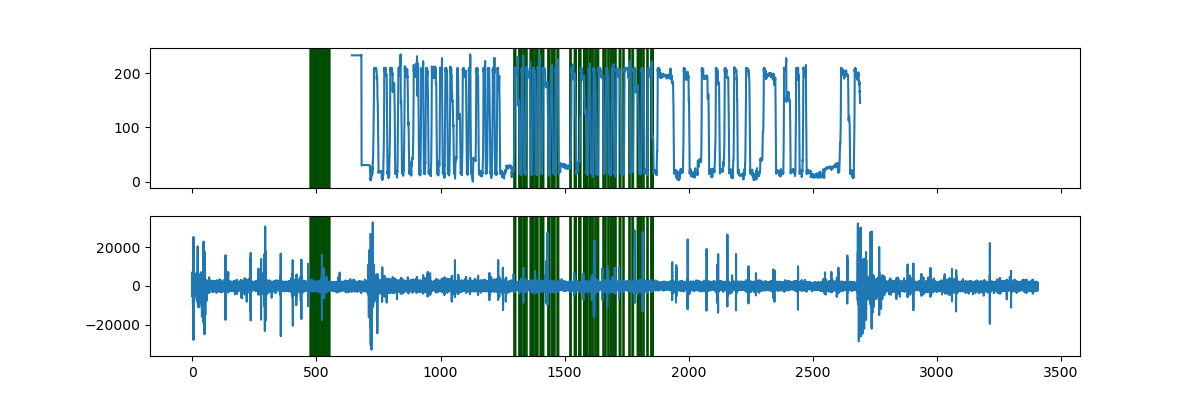

In [84]:
# Stim epochs
%matplotlib widget
theta_chan = 13
_, ax = plt.subplots(2, 1, figsize=(12, 4), sharex=True)
from neuropy.plotting.signals import plot_signal_w_epochs
plot_signal_w_epochs(pos_lin_signal, 0, stim_epochs, ax=ax[0])
plot_signal_w_epochs(sess.eegfile.get_signal().time_slice(channel_id=theta_chan), 0, stim_epochs, ax=ax[1])

### Plot trajectories

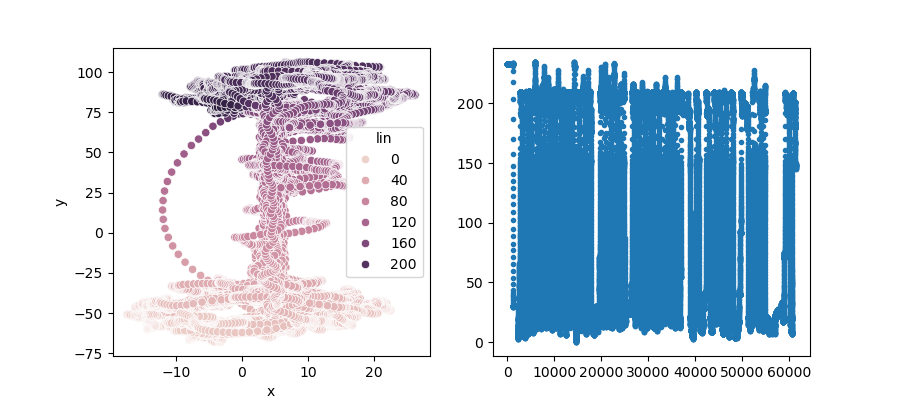

In [85]:
# Color by position, check if linearized position makes sense
_, ax = plt.subplots(1, 2, figsize=(9, 4))
pos_df = pd.DataFrame({"x": position.traces[0], "y": position.traces[2], "lin": position_lin.traces[0]})
# ax[0].plot(position.traces[0], position.traces[2], '.')
sns.scatterplot(data=pos_df, x="x", y="y", hue="lin", ax=ax[0])
ax[1].plot(position_lin.traces[0], '.')

Text(0.5, 0, 'Time (s)')

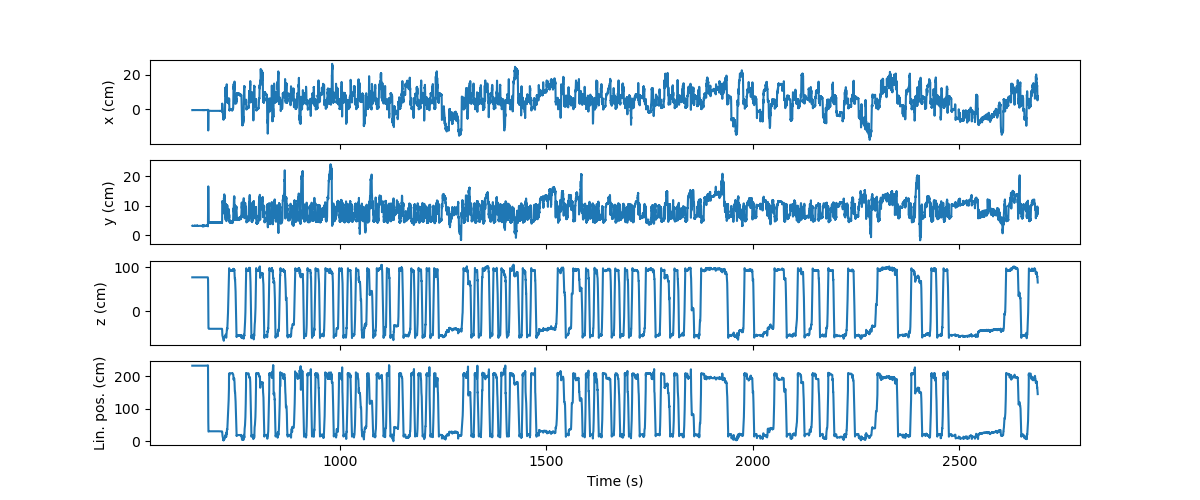

In [86]:
# Plot x/y/z dimensions and linear position
_, ax = plt.subplots(4, 1, figsize=(12, 5), sharex=True)
for a, dim, name in zip(ax, position.traces, ["x", "y", "z"]):
    a.plot(position.time, dim)
    a.set_ylabel(f"{name} (cm)")

ax[3].plot(position_lin.time, position_lin.traces[0])
ax[3].set_ylabel('Lin. pos. (cm)')
ax[3].set_xlabel('Time (s)')

### Check alignment: Get theta and compare to speed

In [87]:
theta_chan = 13
signal = sess.eegfile.get_signal().time_slice(channel_id=theta_chan)

#### Detect ripples and theta

In [88]:
from neuropy.analyses.oscillations import detect_theta_epochs, detect_ripple_epochs
theta_epochs, theta_power = detect_theta_epochs(signal, return_power=True)

Best channel for theta: [13]
755 epochs remaining with durations within (0.25,5)


<Axes: >

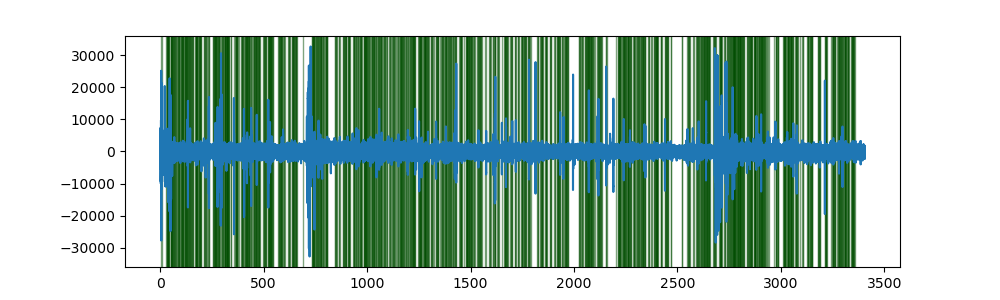

In [89]:
_, ax = plt.subplots(figsize=(10, 3))
plot_signal_w_epochs(signal, 0, theta_epochs, ax=ax)

In [90]:
ripple_epochs = detect_ripple_epochs(signal, ripple_channel=theta_chan)

Selected channels for ripples: [13]
1359 epochs remaining with durations within (0.05,0.45)


<Axes: >

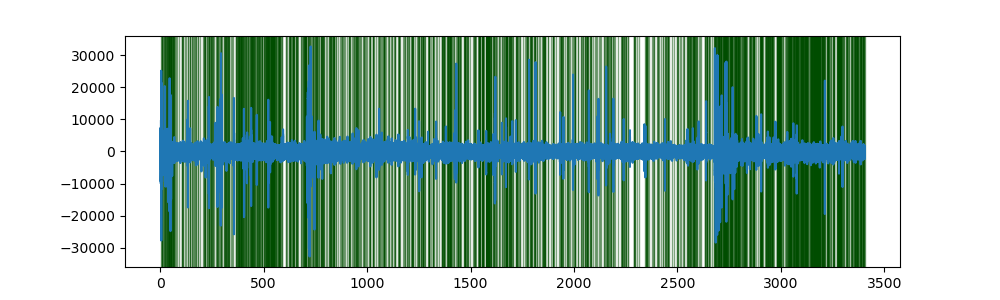

In [91]:
_, ax = plt.subplots(figsize=(10, 3))
plot_signal_w_epochs(signal, 0, ripple_epochs, ax=ax)

In [92]:
maze_ripple_epochs = ripple_epochs.time_slice(t_start=position.t_start, t_stop=position.t_stop)
maze_ripple_epochs

604 epochs
Snippet: 
       start      stop  peak_time  peak_power label
0  644.2120  644.3072   644.2672    4.813467      
1  644.3352  644.4376   644.3712    6.685516      
2  645.4376  645.5080   645.4608    4.464709      
3  657.0496  657.1432   657.0816    2.841416      
4  658.4328  658.5080   658.4616    4.426715      

#### Plot theta power and speed / position together

Text(0, 0.5, 'Theta Power')

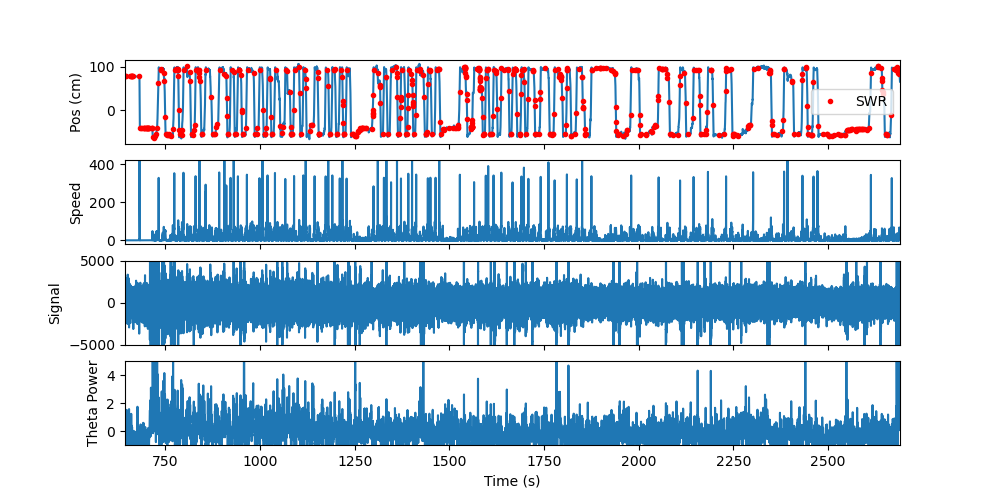

In [104]:
# Interpolate theta power to position times and plot
theta_power_pos = np.interp(position_lin.time, signal.time, theta_power)
_, ax = plt.subplots(4, 1, figsize=(10, 5), sharex=True)
htraj, = ax[0].plot(position_lin.time, position.z)
ripple_peak_times = maze_ripple_epochs.to_dataframe()["peak_time"].values
rip_times_pos = np.interp(ripple_peak_times, position_lin.time, position_lin.time)
rip_pos_pos = np.interp(ripple_peak_times, position_lin.time, position.z)
hrip, = ax[0].plot(rip_times_pos, rip_pos_pos, 'r.', label="SWR")
ax[0].legend()
ax[0].set_ylabel("Pos (cm)")
ax[0].set_xlim([position_lin.t_start, position_lin.t_stop])

ax[1].plot(position_lin.time, position_lin.speed)
ax[1].set_ylabel("Speed")

ax[1].set_ylim([-20, 420])
ax[2].plot(signal.time, signal.traces[0])
ax[2].set_ylabel('Signal')
ax[2].set_ylim([-5000, 5000])

ax[3].plot(position_lin.time, theta_power_pos)
# ax[3].plot(signal.time, theta_power)
ax[3].set_ylim((-1, 5))
ax[3].set_xlabel('Time (s)')
ax[3].set_ylabel('Theta Power')

### Plot theta power vs. speed - looks funky

In [105]:
# Make data into dataframe
theta_df = pd.DataFrame({"speed": position_lin.speed, "theta_power": theta_power_pos})

<Axes: xlabel='speed', ylabel='Count'>

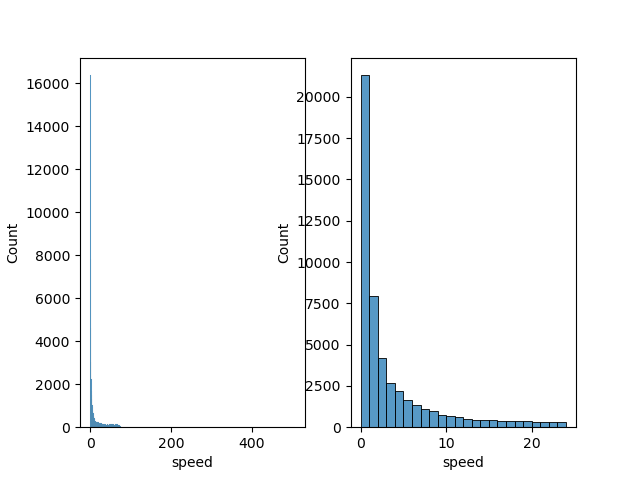

In [106]:
_, ax = plt.subplots(1, 2, )
sns.histplot(data=theta_df, x="speed", ax=ax[0])
sns.histplot(data=theta_df, x="speed", bins=np.arange(25), ax=ax[1])

<Axes: xlabel='speed_binned', ylabel='theta_power'>

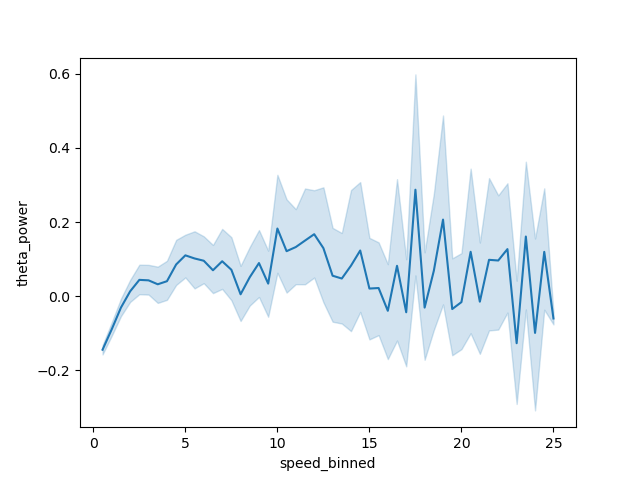

In [107]:
_, ax = plt.subplots()
bin_lim = 25
bin_size = 0.5
theta_df["speed_binned"] = np.arange(0, bin_lim + bin_size, bin_size)[np.digitize(theta_df["speed"], np.arange(0, bin_lim, bin_size))]
sns.lineplot(data=theta_df, x="speed_binned", y="theta_power", ax=ax)

In [108]:
np.arange(0, 100, 1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [109]:
theta_df['speed']

0         0.000000
1         0.011764
2         0.012047
3         0.003380
4         0.000402
           ...    
61403    13.239350
61404    12.536144
61405    10.262734
61406     7.048870
61407     3.525133
Name: speed, Length: 61408, dtype: float64

In [110]:
np.arange(0, 102, 1)[np.digitize(theta_df["speed"], np.arange(0, 101, 1))]

array([ 1,  1,  1, ..., 11,  8,  4])

In [111]:
np.digitize(theta_df["speed"], np.arange(0, 101, 1))

array([ 1,  1,  1, ..., 11,  8,  4])

In [116]:
theta_power_pos[position.speed > 10].mean()
# theta_power_pos[position.speed < 10].mean()

0.012274189276032781

In [172]:
phy_dir = sorted(sess.basepath.glob("**/params.py"))[0].parent
sess.phy = PhyIO(dirname=phy_dir)
sess.neurons = Neurons(sess.phy.spiketrains, t_stop=sess.eegfile.duration, neuron_ids=sess.phy.neuron_ids,
                       neuron_type=sess.phy.cluster_info["q"], waveforms=sess.phy.waveforms, 
                       waveforms_amplitude=sess.phy.waveforms_amplitude, sampling_rate=sess.recinfo.dat_sampling_rate,
                       peak_channels=sess.phy.peak_channels, clu_q=sess.phy.clu_q, shank_ids=sess.phy.shank_ids)
neurons=sess.neurons

id column does not exist in cluster_info.tsv. Using cluster_id column instead.


In [185]:
neurons.neuron_ids

0      72
1      78
2      81
3      87
4      89
5      91
6      97
7     114
8     122
9     124
10    126
11    131
12    148
13    151
14    155
15    159
16    161
17    165
18    169
19    205
20    207
21    211
22    221
23    239
24    241
25    243
26    251
27    273
28    276
29    280
30    282
31    284
32    288
33    294
34    302
35    304
36    322
37    325
38    337
39    341
Name: id, dtype: int64

In [195]:
indexes = neurons.neuron_ids[neurons.neuron_ids.isin(pfmaze.neuron_ids)].index
sliced_indexes = indexes[indexes.isin(n_ind)]
sliced_indexes

Int64Index([4, 5, 7, 8, 9, 10, 11, 15, 17, 18, 22, 23, 30, 31, 32, 35, 38, 39], dtype='int64')

In [190]:
#test_neurons = neurons.get_neuron_type([1, 2, 3])
n_ind = [3, 4, 5, 7, 8, 9, 10, 11, 15, 17, 18, 22, 23, 27, 29, 30, 31, 32, 35, 37, 38, 39]
#test_neurons = neurons.neuron_slice(n_ind)
#test_neurons.neuron_ids

In [196]:
# Get base file names for RatU Day2 NSD data from track running.
#data_dir = Path(neuropy_dir) / "examples" / "Data"
#file_use = data_dir / "RatU_Day2NSD_2021-07-24_08-16-38"
#neurons = Neurons.from_file(file_use.with_suffix(".neurons_stable_maze.npy"), convert=True)
#maze = Position.from_file(file_use.with_suffix(".maze.linear.npy"), convert=True)
kw = dict(frate_thresh=0, grid_bin=5)  # Define placefield parameters

pfmaze = Pf1D(neurons, position=position_lin, speed_thresh=2.5,**kw)  # Create placefield object

0      72
1      78
2      81
3      87
4      89
5      91
6      97
7     114
8     122
9     124
10    126
11    131
12    148
13    151
14    155
15    159
16    161
17    165
18    169
19    205
20    207
21    211
22    221
23    239
24    241
25    243
26    251
27    273
28    276
29    280
30    282
31    284
32    288
33    294
34    302
35    304
36    322
37    325
38    337
39    341
Name: id, dtype: int64


In [186]:
pfmaze.neuron_ids

array([ 72,  78,  81,  89,  91,  97, 114, 122, 124, 126, 131, 148, 151,
       155, 159, 161, 165, 169, 205, 207, 211, 221, 239, 241, 243, 251,
       276, 282, 284, 288, 294, 302, 304, 322, 337, 341])

In [197]:
pfmaze = pfmaze.neuron_slice(inds=n_ind)

### Plot animal behavior on track

In [198]:
position_lin.x

array([232.88105715, 232.8814493 , 232.88185086, ..., 145.569627  ,
       145.33466465, 145.21716023])

Text(0, 0.5, 'Distance (cm)')

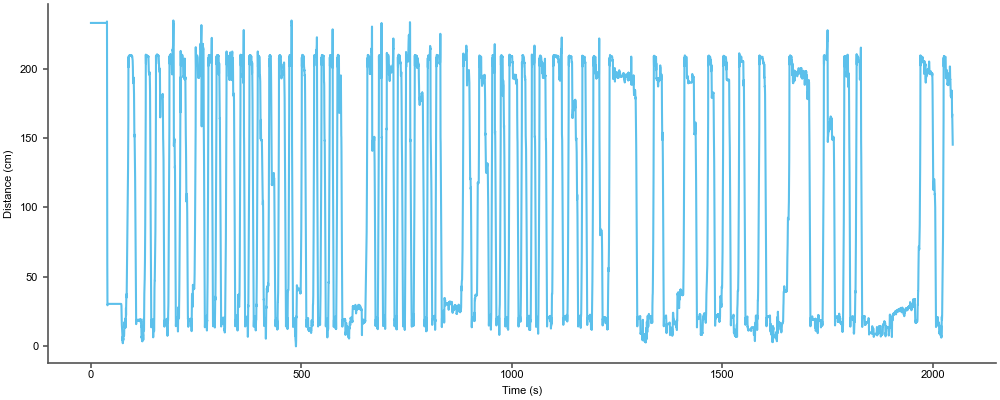

In [199]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(position_lin.time - position_lin.t_start, position_lin.x)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance (cm)')

### Plot all placefields

<Axes: xlabel='Position'>

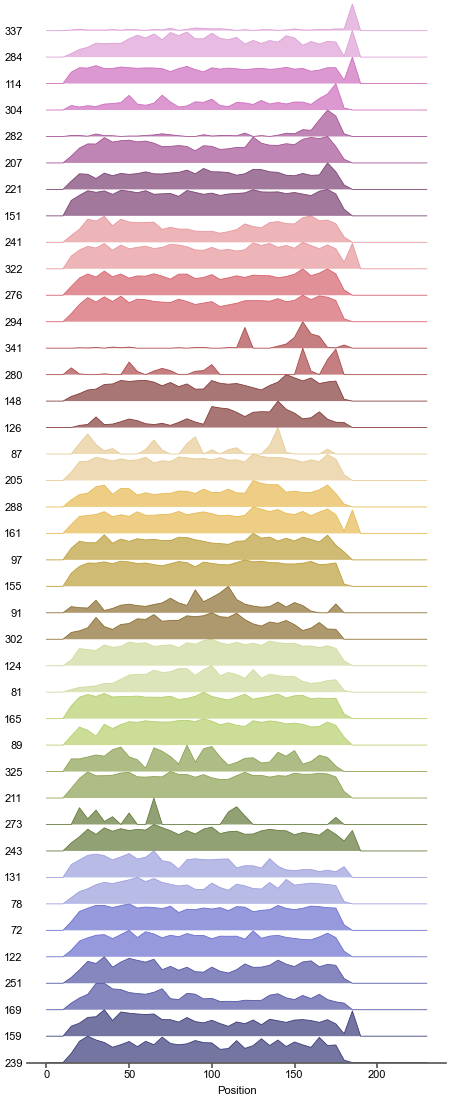

In [266]:
#pfmaze_ds = pfmaze.neuron_slice(list(np.arange(36, dtype=int)))  # Keep only 40 neurons to make visualization more manageable
pfmaze.plot_ratemaps(normalize_tuning_curve=True)

### Now plot placefields with rasters

In [285]:
# Grab one neuron from the beginning, middle, and end, both by index and by id
ids = [91,126,304] 
inds = [20, 36, 38] # or [np.where(id == pfmaze_ds.neuron_ids)[0][0] for id in ids]

In [290]:
pos_bool = (position_lin.x > 25) & (position_lin.x < 180)
test_pos_epoch = Epoch.from_boolean_array(pos_bool, position_lin.time)
pfmaze = Pf1D(neurons, epochs=test_pos_epoch, position=position_lin, speed_thresh=2.5,**kw)  # Create placefield object
#pfmaze = pfmaze.neuron_slice(inds=n_ind)

0      72
1      78
2      81
3      87
4      89
5      91
6      97
7     114
8     122
9     124
10    126
11    131
12    148
13    151
14    155
15    159
16    161
17    165
18    169
19    205
20    207
21    211
22    221
23    239
24    241
25    243
26    251
27    273
28    276
29    280
30    282
31    284
32    288
33    294
34    302
35    304
36    322
37    325
38    337
39    341
Name: id, dtype: int64
Note: speed_thresh is ignored when epochs is provided


#### Loop through by id and plot raster for each neuron

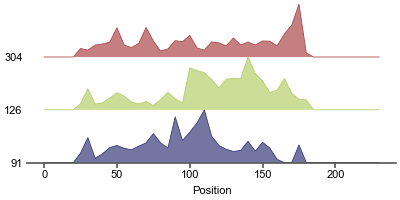

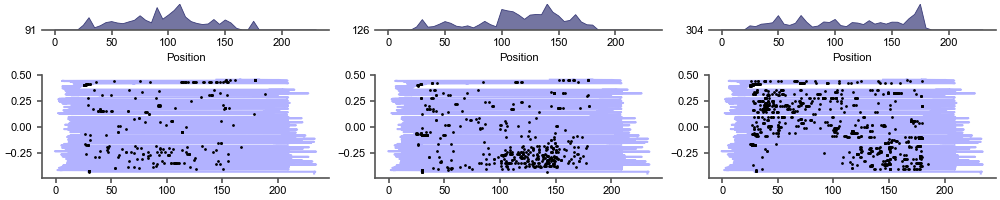

In [291]:
_, ax = plt.subplots(1, 1, figsize=(4, 2))
pfmaze.neuron_slice(ids=ids).plot_ratemaps(normalize_tuning_curve=True, ax=ax)
_, ax2 = plt.subplots(2, 3, figsize=(10, 2), height_ratios=[1, 4])
for id, a in zip(ids, ax2.T):
    pfmaze.plot_ratemap_w_raster(id=id, ax=a)

#### Same but plot by index this time

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(4, 2))
pfmaze_ds.neuron_slice(ids=ids).plot_ratemaps(normalize_tuning_curve=True, ax=ax)
_, ax2 = plt.subplots(2, 3, figsize=(10, 2), height_ratios=[1, 4])
for ind, a in zip(inds, ax2.T):
    pfmaze_ds.plot_ratemap_w_raster(ind=ind, ax=a)